<a href="https://colab.research.google.com/github/fabarj4/seaweed_detection/blob/master/seaweed_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

---



In [ ]:
#@ Install Dependecis
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install jupyter
!pip install matplotlib
!pip install -q tf-nightly

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,791 kB of archives.
After this operation, 7,807 kB of additional disk space will be used.
Get:1 htt

In [ ]:
#@title import function dan library
import os
import pathlib

import cv2
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
import PIL
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import datasets,layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')

tf.get_logger().setLevel('ERROR')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Example

## example - tensorflow - cnn

---



In [ ]:
(train_images, train_labels), (test_images,test_labels)= datasets.cifar10.load_data()
train_images, test_images = train_images/255.0, test_images/255.0

class_names = ['pesawat','mobil','burung','kucing','rusa','anjing','katak','kuda','perahu','truk']
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i],cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])
plt.show()

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)


## Example - tensorflow - image clasification

---



import data set bunga

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos',origin=dataset_url,untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

/root/.keras/datasets/flower_photos
3670


ambil gambar dari dataset

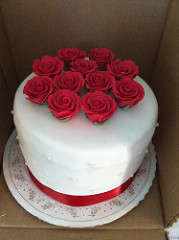

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

Buat set data

In [ ]:
batch_size = 32
img_height = 180
img_widht = 180

Training data

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_widht),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


validation data

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_widht),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


print nama class

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


visualisasi data dari train data

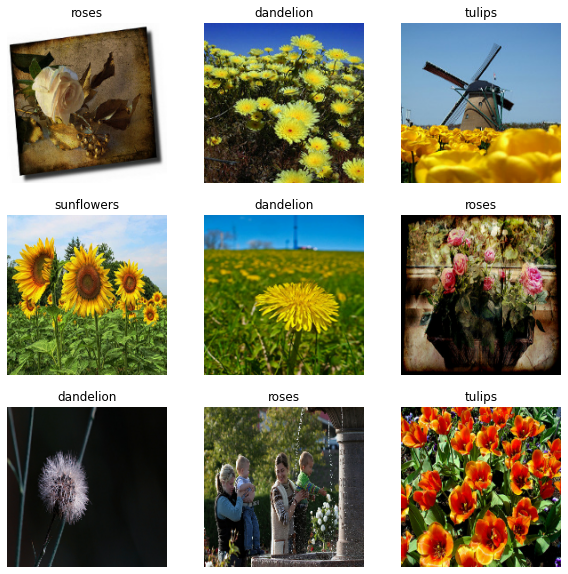

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

konfigurasi set data untuk kinerja

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

standarisasi data

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

AttributeError: ignored

In [ ]:
normalized_ds = train_ds.map(lambda x,y:(normalization_layer(x),y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


buat model

In [ ]:
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_widht, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)           
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


train model

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

visualasiasi hasil pelatihan

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Example - tensorflow - Custom Dataset

In [ ]:
dir = '/content/drive/My Drive/citra rumput laut/'

img = cv2.imread(dir + 'DJI_0020.JPG')

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.subplot(1,1,1)
plt.imshow(img_rgb)
plt.show()

# Prototype

---



In [ ]:
#@title import function dan library. (ketuk dua kali untuk edit)
import os
import pathlib

import cv2
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
import PIL
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import datasets,layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
from google.colab import files

tf.get_logger().setLevel('ERROR')

## setup

In [ ]:
#@title Form setup data
train_dir = '/content/drive/My Drive/Colab Notebooks/train' #@param {type:"string"}

batch_size = 32 #@param {type:"integer"}
img_height = 180 #@param {type:"integer"}
img_width = 180 #@param {type:"integer"}

## core engine

### pembuatan dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 75 files belonging to 2 classes.
Using 60 files for training.
Found 75 files belonging to 2 classes.
Using 15 files for validation.


visualisasi dataset

['laut', 'rumput_laut']


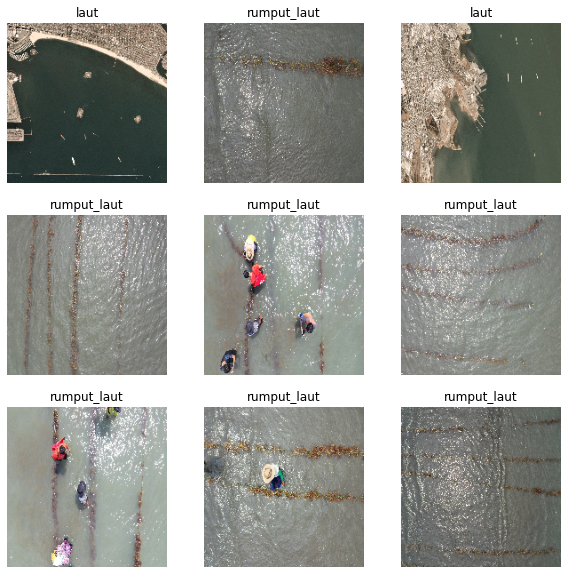

In [ ]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### learning dataset

konfig autotune untuk dataset

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

konfig standarisasi data

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.04814778 1.0


buat model

In [ ]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

train model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 23s 12s/step - loss: 1.0972 - accuracy: 0.4833 - val_loss: 0.4864 - val_accuracy: 0.9333
Epoch 2/10
2/2 [==============================] - 0s 34ms/step - loss: 0.6349 - accuracy: 0.8833 - val_loss: 0.2814 - val_accuracy: 0.9333
Epoch 3/10
2/2 [==============================] - 0s 32ms/step - loss: 0.3046 - accuracy: 0.8833 - val_loss: 0.2193 - val_accuracy: 0.9333
Epoch 4/10
2/2 [==============================] - 0s 30ms/step - loss: 0.2261 - accuracy: 0.8833 - val_loss: 0.1998 - val_accuracy: 0.9333
Epoch 5/10
2/2 [==============================] - 0s 29ms/step - loss: 0.1975 - accuracy: 0.9000 - val_loss: 0.1811 - val_accuracy: 0.9333
Epoch 6/10
2/2 [==============================] - 0s 28ms/step - loss: 0.1314 - accuracy: 0.9500 - val_loss: 0.1634 - val_accuracy: 0.9333
Epoch 7/10
2/2 [==============================] - 0s 29ms/step - loss: 0.0894 - accuracy: 0.9833 - val_loss: 0.1585 - val_accuracy: 0.9333
Epoch 8/10
2/2 [===========

### visualisasi hasil train model

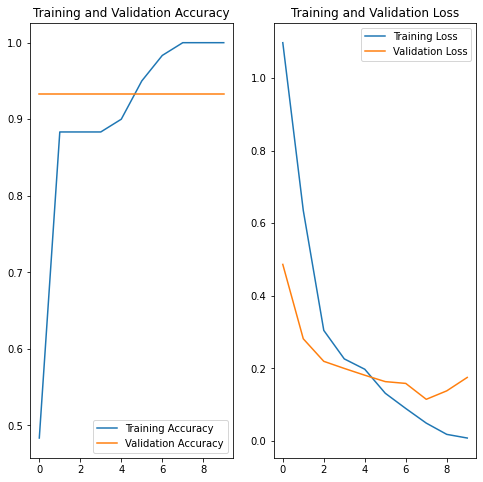

In [ ]:
#@title ketuk dua kali untuk melihat kode
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### reduksi overfitting

membuat agumentasi data

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

visualsi augemntasi data

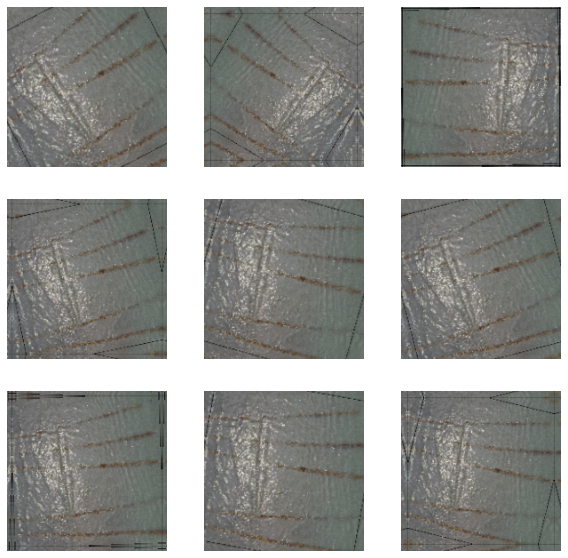

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")



dropdout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

buat model dan latih kembali

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### visualisasi hasil reduksi overfitting

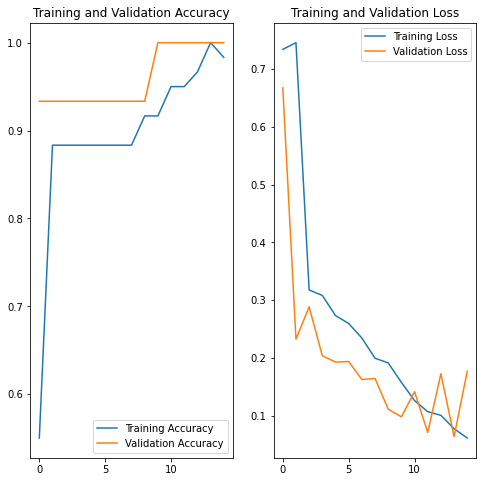

In [ ]:
#@title ketuk dua kali ini untuk melihat kode
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Aplikasi Rumput Laut


In [ ]:
#@title Identifikasi Citra Rumput Laut

#menghapus citra yang sudah diupload sebelumnya
for name in os.listdir():
  if name == '.config' or name == '.ipynb_checkpoints':
    continue
  if len(name.split('.')) >= 2 :
    os.remove('/content/'+name)

upload = files.upload()
print()
print()
for name, data in upload.items():
  with open(name, 'wb') as f:
    f.write(data)
    img_location = '/content/' + name
    img = keras.preprocessing.image.load_img(
        img_location, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(
        "{} most likely belongs to {} with a {:.2f} percent confidence."
        .format(name, class_names[np.argmax(score)], 100 * np.max(score))
    )
    print()


Saving rumput laut apung.jpg to rumput laut apung.jpg
Saving WhatsApp Image 2020-09-02 at 21.19.20.jpeg to WhatsApp Image 2020-09-02 at 21.19.20.jpeg
Saving seaweed1.jpeg to seaweed1.jpeg
Saving Rumput-laut-03.jpg to Rumput-laut-03.jpg


rumput laut apung.jpg most likely belongs to rumput_laut with a 99.44 percent confidence.

WhatsApp Image 2020-09-02 at 21.19.20.jpeg most likely belongs to laut with a 87.22 percent confidence.

seaweed1.jpeg most likely belongs to laut with a 85.25 percent confidence.

Rumput-laut-03.jpg most likely belongs to rumput_laut with a 96.28 percent confidence.

